In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import yaml
#for ipynb
%matplotlib inline

In [2]:
in_dict = {'BRCA_Ghana':['../BRCA_Ghana','../../../../data/cfDNA_Ghana-BRCA_hg38/analysis/Ghana_MBC_metrics.txt','ER_status'],
           'MBC_Dawson_downsampled':['../MBC_Dawson_downsampled','/fh/fast/ha_g/user/adoebley/data/cfDNA_MBC-Dawson/analysis/MBC-Dawson-downsampled_ULP_metrics.txt','ER_status'],
           'MBC_Stover':['../MBC_Stover','/fh/fast/ha_g/user/adoebley/data/cfDNA_Stover-Lab-MBC-ULP_hg38/analysis/Stover_MBC_metrics.txt','HR status']}


In [3]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [4]:
start_time = time.time()
data = pd.DataFrame()
for group in in_dict.keys():
    #get list of samples
    samples_yaml = in_dict[group][0]+'/config/samples.GC.yaml'
    with open(samples_yaml, 'r') as f:
        samples = yaml.safe_load(f)
    samples = samples['samples']
    samples = list(samples.keys())  
    print(group,len(samples))
    
    #get files for import
    in_files = []
    in_dir = in_dict[group][0]+'/results'
    for sample in samples:
        in_files.append(in_dir+'/'+sample+'/'+sample+'.GC_corrected.coverage.tsv')
    print(group,len(in_files))   
    
    #import data
    current_data = pd.DataFrame()
    for i,file in enumerate(in_files):
        #if i%100==0:
            #print(i,'importing',file,np.round(time.time()-start_time))
        current = pd.read_csv(file,sep='\t')
        current_data = current_data.append(current, ignore_index=True)
    print(len(current_data))
    non_metadata_columns = current_data.columns
        
    #import metadata
    metadata = pd.read_csv(in_dict[group][1], sep='\t')
    status_col = in_dict[group][2]
    metadata['status'] = metadata[status_col].replace(['ER+','HR+/HER2-'],1).replace(['ER-','TNBC'],0)
    metadata['dataset'] = group
    metadata = metadata.rename(columns = {'Patient ID':'patient_ID'})
    current_data = current_data.merge(metadata, on = 'sample')
    
    print(len(current_data))
    print('\n')
    
    data = data.append(current_data)
    

BRCA_Ghana 30
BRCA_Ghana 30
120
120


MBC_Dawson_downsampled 27
MBC_Dawson_downsampled 27
108
108


MBC_Stover 103
MBC_Stover 103
412
412




In [5]:
#remove samples with unknown status
print('total samples:',len(data[['sample','dataset']].drop_duplicates()))
print(data[['sample','dataset','status']].drop_duplicates()['status'].value_counts())
data = data[data['status'].isin([0,1])].copy()

#get site group (should only be one)
data['site_group'] = data['site_name'].str.rsplit('.',1,expand=True)[1]

#get metadata columns 
metadata_columns = ['sample'] + list(data.drop(columns = non_metadata_columns).columns) + ['site_name']

#split Ghana dataset into ULP and 30x
data['dataset'] = np.where(data['sample'].str.contains('_01x'),'BRCA_Ghana_ULP',data['dataset'])

#remove deepWGS 
data = data[data['dataset'].isin(['MBC_Stover','BRCA_Ghana_ULP','MBC_Dawson_downsampled'])]

print('known_subtype:',len(data[['sample','dataset']].drop_duplicates()))


total samples: 160
1          84
0          74
unknown     2
Name: status, dtype: int64
known_subtype: 144


In [6]:
data[['sample','patient_ID','dataset']].drop_duplicates()

,sample,patient_ID,dataset
56,P15_01x,P15,BRCA_Ghana_ULP
60,P11_01x,P11,BRCA_Ghana_ULP
64,P04_01x,P04,BRCA_Ghana_ULP
68,P10_01x,P10,BRCA_Ghana_ULP
72,P12_01x,P12,BRCA_Ghana_ULP
...,...,...,...
392,B-515465_6,B-515465,MBC_Stover
396,B-515465_4,B-515465,MBC_Stover
400,B-515465_3,B-515465,MBC_Stover
404,B-521244_2,B-521244,MBC_Stover


In [7]:
#total samples in each dataset post dropping unlabeled samples
data[['sample','patient_ID','dataset']].drop_duplicates()['dataset'].value_counts()

MBC_Stover                103
MBC_Dawson_downsampled     27
BRCA_Ghana_ULP             14
Name: dataset, dtype: int64

In [8]:
print('total stover samples',len(data[data['dataset']=='MBC_Stover'][['sample','patient_ID']].drop_duplicates()))
print('total stover patients',len(data[data['dataset']=='MBC_Stover'][['patient_ID']].drop_duplicates()))
print(data[data['dataset']=='MBC_Stover'][['patient_ID','HR status']].drop_duplicates()['HR status'].value_counts())

total stover samples 103
total stover patients 30
TNBC         15
HR+/HER2-    15
Name: HR status, dtype: int64


In [9]:
data

,-990,-975,-960,-945,-930,-915,-900,-885,-870,-855,...,sample,coverage,ER_status,tumor_fraction,patient_ID,status,dataset,HR status,timepoint_within_pt_ctDNAonly,site_group
56,1.01385,0.97289,0.97984,0.95484,0.95384,0.98108,0.99598,0.98478,0.98116,0.98069,...,P15_01x,0.108634,ER+,0.018150,P15,1,BRCA_Ghana_ULP,NaN,NaN,5e-4_qval
57,1.10060,1.02848,0.99320,0.97403,0.97217,0.95202,0.96424,0.97625,1.00613,1.00544,...,P15_01x,0.108634,ER+,0.018150,P15,1,BRCA_Ghana_ULP,NaN,NaN,5e-4_qval
58,0.98146,0.96129,0.92970,0.92379,0.93627,0.92089,0.91233,0.89145,0.90360,0.90694,...,P15_01x,0.108634,ER+,0.018150,P15,1,BRCA_Ghana_ULP,NaN,NaN,5e-4_qval
59,0.93537,0.93501,0.93644,0.94901,0.96054,0.94231,0.98610,1.00874,1.03140,1.01324,...,P15_01x,0.108634,ER+,0.018150,P15,1,BRCA_Ghana_ULP,NaN,NaN,5e-4_qval
60,0.96895,0.94855,0.96638,0.98829,0.99114,1.01945,1.02403,1.04152,1.06004,1.04225,...,P11_01x,0.122657,ER+,0.022830,P11,1,BRCA_Ghana_ULP,NaN,NaN,5e-4_qval
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.90864,0.94767,0.98334,1.03942,1.04929,1.05759,1.04099,1.03672,1.02554,1.03258,...,B-521244_2,0.109191,NaN,0.071430,B-521244,1,MBC_Stover,HR+/HER2-,2.0,5e-4_qval
408,0.98989,0.95861,0.95701,0.96041,0.96258,0.96069,0.95374,0.99130,0.97181,1.00667,...,B-518638_7,0.086952,NaN,0.008248,B-518638,0,MBC_Stover,TNBC,7.0,5e-4_qval
409,0.96922,0.99133,0.97581,0.93966,0.96199,0.97750,1.00531,1.04986,1.10510,1.13712,...,B-518638_7,0.086952,NaN,0.008248,B-518638,0,MBC_Stover,TNBC,7.0,5e-4_qval
410,0.98228,0.97454,0.99512,1.04746,1.04717,1.05580,1.00097,0.96175,0.96534,0.97432,...,B-518638_7,0.086952,NaN,0.008248,B-518638,0,MBC_Stover,TNBC,7.0,5e-4_qval


In [10]:
#get the key columns
data = data[metadata_columns+['central_coverage','amplitude','mean_coverage']+str_plot_columns]

print(len(data))


for group,df in data.groupby('site_group'):
    print(group,len(df['site_name'].unique()))

    #df.to_csv('merged_data/'+group+'_data_with_features.txt', sep='\t', index=False)
    
    #reformat for logistic regression
    reformatted = df[metadata_columns+['central_coverage','amplitude','mean_coverage']]
    reformatted = reformatted.set_index(metadata_columns).unstack()
    new_column_names = []
    for item in reformatted.columns.values:
        new_column_names.append('_'.join(item))
    reformatted.columns = new_column_names
    reformatted.to_csv('merged_data/'+group+'_validation_reformatted.txt', sep='\t')
    print(reformatted.shape)

576
5e-4_qval 4
(144, 12)


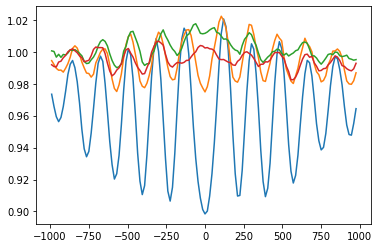

In [11]:
#plot
for site_name in data['site_name'].unique():
    current = data[data['site_name']==site_name][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    
# plt.legend()



fft real -0.27344126763755816
fft imag -0.13260504744126517
fft magn 0.30389838014397985
sum x coords -0.2734412676375717
sum y coords -0.13260504744128715
magnitude: 0.30389838014400167


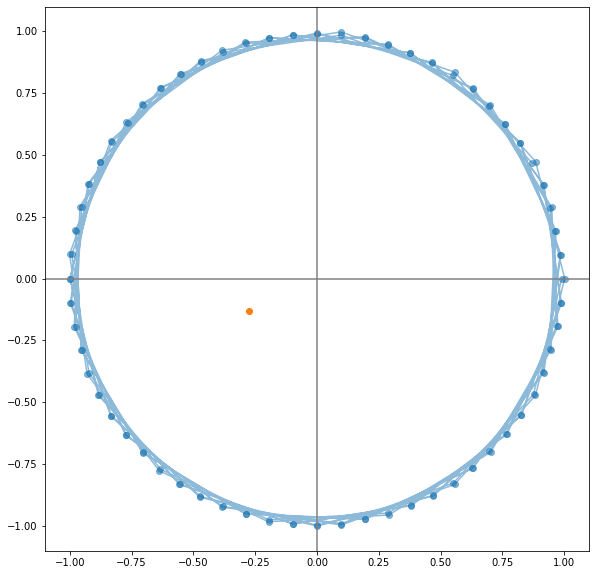

In [12]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [13]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)